# Imports

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import matplotlib.pyplot as plt

# Pre-Processing

In [19]:
# Load and combine data
PATH_TO_FILE_1 = "../raw data/aapl_2016_2020.csv"
PATH_TO_FILE_2 = "../raw data/aapl_2021_2023.csv"
half_1 = pd.read_csv(PATH_TO_FILE_1, low_memory=False)
half_2 = pd.read_csv(PATH_TO_FILE_2, low_memory=False)
df = pd.concat([half_1, half_2], ignore_index=True)
df.columns = df.columns.str.strip()

# Option type
option_type = "put"

# Convert Unix timestamps to datetime
df['QUOTE_DATETIME'] = pd.to_datetime(df['[QUOTE_UNIXTIME]'], unit='s')
df['EXPIRE_DATETIME'] = pd.to_datetime(df['[EXPIRE_UNIX]'], unit='s')

# Load underlying price data for volatility computation
underlying_prices = df[['QUOTE_DATETIME', '[UNDERLYING_LAST]']].drop_duplicates().set_index('QUOTE_DATETIME').sort_index()

# Function to compute historical volatility
def historical_volatility(series, window=20):
    return np.sqrt(252) * series.pct_change().rolling(window=window).std()

# Compute 20-day historical volatility
underlying_prices['hist_vol_20d'] = historical_volatility(underlying_prices['[UNDERLYING_LAST]'])
underlying_prices.dropna(inplace=True)

# Merge historical volatility back into main dataframe
df = df.merge(underlying_prices[['hist_vol_20d']], left_on='QUOTE_DATETIME', right_index=True, how='inner')

# Columns to numeric conversion: choose columns based on option type
if option_type == 'call':
    numeric_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]',
                    '[C_THETA]', '[C_RHO]', '[C_BID]', '[C_ASK]']
else:
    numeric_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]',
                    '[P_THETA]', '[P_RHO]', '[P_BID]', '[P_ASK]']

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Calculate mid-price based on option type
if option_type == 'call':
    df['CALL_EQUI_PRICE'] = (df['[C_BID]'] + df['[C_ASK]']) / 2
else:
    df['PUT_EQUI_PRICE'] = (df['[P_BID]'] + df['[P_ASK]']) / 2

# Drop rows with missing essential data (dynamically chosen based on option type)
essential_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', 'hist_vol_20d']
if option_type == 'call':
    essential_cols.append('CALL_EQUI_PRICE')
else:
    essential_cols.append('PUT_EQUI_PRICE')
df.dropna(subset=essential_cols, inplace=True)

# Prepare option data based on the option type
if option_type == 'call':
    option_cols = ['[UNDERLYING_LAST]', '[STRIKE]', '[DTE]', 'hist_vol_20d', 
                   '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]', '[C_THETA]', '[C_RHO]', 'CALL_EQUI_PRICE']
    col_rename = ['underlying_price', 'strike_price', 'days_to_expiry', 'hist_volatility', 
                  'delta', 'gamma', 'vega', 'theta', 'rho', 'equilibrium_price']
    output_file = 'processed_calls_data.csv'
    model_file = 'call-mlp1.h5'
else:
    option_cols = ['[UNDERLYING_LAST]', '[STRIKE]', '[DTE]', 'hist_vol_20d', 
                   '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]', '[P_THETA]', '[P_RHO]', 'PUT_EQUI_PRICE']
    col_rename = ['underlying_price', 'strike_price', 'days_to_expiry', 'hist_volatility', 
                  'delta', 'gamma', 'vega', 'theta', 'rho', 'equilibrium_price']
    output_file = 'processed_puts_data.csv'
    model_file = 'put-mlp1.h5'

option_df = df[option_cols].copy()
option_df.columns = col_rename

# Normalize strike price and compute time to expiry in years
option_df['strike_price'] = option_df['strike_price'] / 1000
option_df['time_to_expiry'] = option_df['days_to_expiry'] / 365
option_df.drop('days_to_expiry', axis=1, inplace=True)

print(option_df.sample(10))

         underlying_price  strike_price  hist_volatility    delta    gamma  \
684948              98.79        0.2050         0.194189 -0.74214  0.00044   
1163109            166.22        0.2200         0.230020 -0.90220  0.00055   
1537084            167.18        0.1430         0.266991 -0.08535  0.00771   
161119             127.75        0.0675         0.287401 -0.00391  0.00031   
487278             216.66        0.3250         0.266990 -0.86997  0.00023   
1316048            132.13        0.0650         0.269235 -0.00141  0.00016   
1228715            136.33        0.1220         0.159448 -0.04517  0.01049   
393314             259.43        0.2350         0.190391 -0.28001  0.00659   
1437312            121.21        0.1450         0.384542 -0.96034  0.00702   
263704             246.60        0.3050         1.080739 -0.85667  0.00496   

            vega    theta      rho  equilibrium_price  time_to_expiry  
684948   0.17596 -0.03579 -0.33341            106.855        0.520658

# Hyperparameters

In [20]:
# Hyperparameters
n_units_per_layer = [256, 32, 1]
layers = 3
n_batch = 1024
n_epochs = 50

# Building model

In [21]:
# Prepare data for modeling
X = option_df[['underlying_price', 'strike_price', 'hist_volatility', 'delta', 'gamma', 'vega', 'theta', 'rho', 'time_to_expiry']]
y = option_df['equilibrium_price']


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Create model 
model = Sequential()

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add first layer without ativation
model.add(Dense(n_units_per_layer[0], input_shape=(X_train_scaled.shape[1],)))
model.add(Activation('relu'))

# Define Keras MLP model using LeakyReLU in subsequent layers
for i in range(1, layers - 1):
    model.add(Dense(n_units_per_layer[i]))
    model.add(Activation('relu'))

# Add last layer
model.add(Dense(n_units_per_layer[-1]))
model.add(Activation('relu'))

# Learning rate scheduling
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.1  # reduce LR by 10x every 10 epochs
    return lr

lr_callback = LearningRateScheduler(scheduler)

early_stop = EarlyStopping(
    monitor='val_loss',       # what to monitor
    patience=5,               # how many epochs to wait before stopping
    restore_best_weights=True,  # restores weights from best epoch
    verbose=1
)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,817 (42.25 KB)

 Trainable params: 10,817 (42.25 KB)

 Non-trainable params: 0 (0.00 B)

# Train model

In [22]:
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=n_batch, validation_split=0.2, verbose=1, callbacks=[lr_callback, early_stop])

# Evaluate the model
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f"Test MAE: {mae}")

# Save the model
model.save(model_file)

Epoch 1/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 550.3801 - mae: 9.8448 - val_loss: 3.0188 - val_mae: 1.0550 - learning_rate: 0.0010
Epoch 2/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.4774 - mae: 0.9488 - val_loss: 1.5286 - val_mae: 0.7438 - learning_rate: 0.0010
Epoch 3/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.4074 - mae: 0.7024 - val_loss: 1.0316 - val_mae: 0.6054 - learning_rate: 0.0010
Epoch 4/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8736 - mae: 0.5357 - val_loss: 0.7330 - val_mae: 0.4513 - learning_rate: 0.0010
Epoch 5/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6434 - mae: 0.4329 - val_loss: 0.5014 - val_mae: 0.3950 - learning_rate: 0.0010
Epoch 6/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5690 - mae: 0.3756 - val_loss: 0.6120 - val_mae: 0.3715 - learning_rate: 0.0010
Epoch 7/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4941 - mae: 0.3572 - val_loss: 0.3654 - val_mae: 0.3258 - learning_rat

Test MAE: 0.253744900226593


# Plot the loss

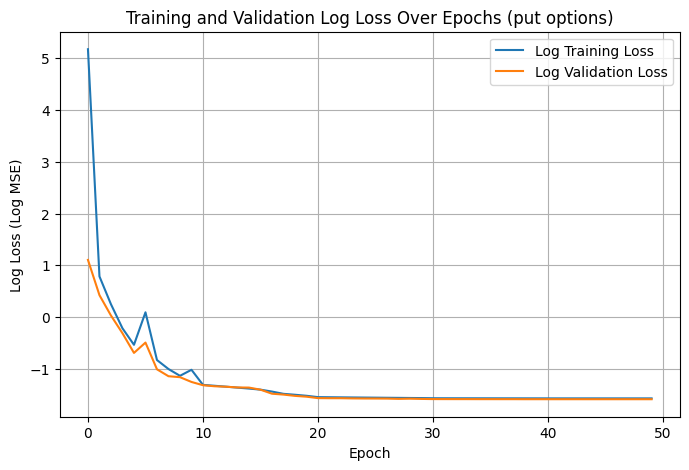

In [23]:
# Plot training and validation loss
plt.figure(figsize=(8,5))

eps = 1e-10  # tiny number to avoid log(0)
plt.plot(np.log(np.array(history.history['loss']) + eps), label='Log Training Loss')
plt.plot(np.log(np.array(history.history['val_loss']) + eps), label='Log Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Log Loss (Log MSE)')
plt.title(f'Training and Validation Log Loss Over Epochs ({option_type} options)')
plt.legend()
plt.grid(True)
plt.show()


Plot the results

4843/4843 ━━━━━━━━━━━━━━━━━━━━ 1s 255us/step


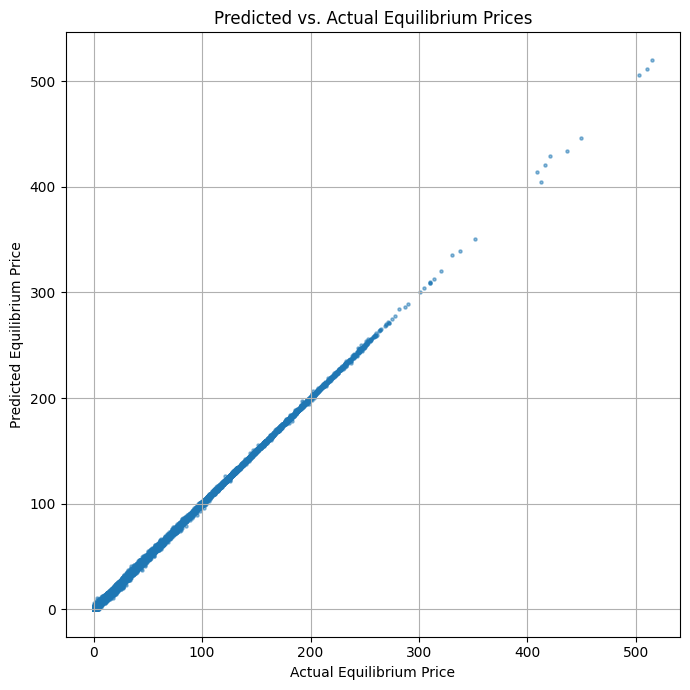

In [24]:
loaded_model = load_model(model_file)

# Predict on test set
y_pred = model.predict(X_test_scaled).flatten()

# Align y_test to numpy array with matching shape
y_test_array = y_test.to_numpy().flatten()

# Plot predicted vs actual
plt.figure(figsize=(7, 7))
plt.scatter(y_test_array, y_pred, s=5, alpha=0.5)
plt.xlabel('Actual Equilibrium Price')
plt.ylabel('Predicted Equilibrium Price')
plt.title('Predicted vs. Actual Equilibrium Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

# Test random entries

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Entry 1329965 - Predicted price: 16.22, Actual price: 16.20
Entry 1201758 - Predicted price: 0.00, Actual price: 0.08
Entry 1031425 - Predicted price: 19.35, Actual price: 20.20
Entry 722611 - Predicted price: 10.99, Actual price: 10.73
Entry 595283 - Predicted price: 11.66, Actual price: 11.15
Entry 449828 - Predicted price: 1.90, Actual price: 2.00
Entry 425445 - Predicted price: 11.66, Actual price: 11.78
Entry 497011 - Predicted price: 27.52, Actual price: 28.20
Entry 1321149 - Predicted price: 0.00, Actual price: 0.14
Entry 890337 - Predicted price: 37.58, Actual price: 37.25
4843/4843 ━━━━━━━━━━━━━━━━━━━━ 1s 285us/step


/var/folders/bk/_nfh05pn5y1bcz9mw5l6lhs80000gn/T/ipykernel_25924/1953852242.py:16: RuntimeWarning: invalid value encountered in divide
  percent_errors = 100 * (y_pred - y_true) / y_true


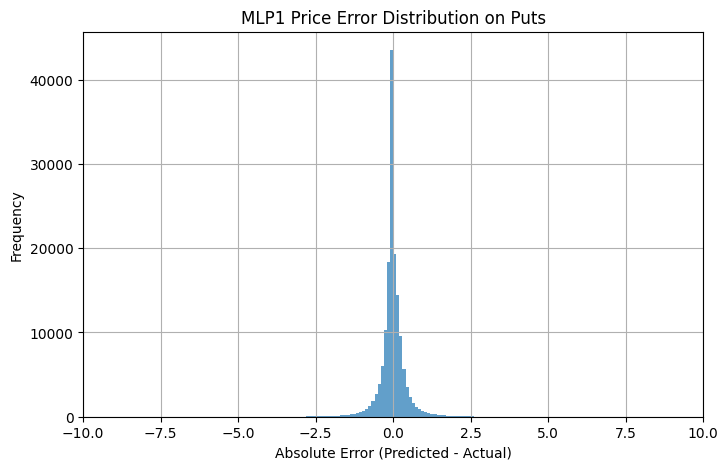

In [27]:
# Test 10 random entries
loaded_model = load_model(model_file)
sample_entries = X.sample(10)
sample_scaled = scaler.transform(sample_entries)
predictions = loaded_model.predict(sample_scaled)

for i, idx in enumerate(sample_entries.index):
    print(f"Entry {idx} - Predicted price: {predictions[i][0]:.2f}, Actual price: {y.loc[idx]:.2f}")

# ---- Full Test Set Error Analysis ----
X_test_scaled = scaler.transform(X_test)
y_pred = loaded_model.predict(X_test_scaled).flatten()
y_true = y_test.values

# Compute percent errors
percent_errors = 100 * (y_pred - y_true) / y_true

bins = np.arange(-200, 201, 2)  # from -100 to +100 with 2% width

# ---- Absolute Error Analysis ----
abs_errors = y_pred - y_true

# Plot histogram of absolute errors
plt.figure(figsize=(8, 5))
plt.hist(abs_errors, bins=np.arange(-10, 10.1, 0.1), alpha=0.7)
plt.xlabel("Absolute Error (Predicted - Actual)")
plt.ylabel("Frequency")
plt.xlim([-10, 10])
plt.title("MLP1 Price Error Distribution on Puts")
plt.grid(True)
plt.show()

In [26]:
loaded_model = load_model("put-mlp1.h5")
y_pred = model.predict(X_test_scaled).flatten()

# Calculate errors
errors = y_test - y_pred
y_true = y_test.values
# Create a mask to filter out zero or near-zero actual prices
valid_mask = np.abs(y_true) > 0

# Apply the mask
y_true_valid = y_true[valid_mask]
y_pred_valid = y_pred[valid_mask]

# Now calculate percent errors without worrying about divide-by-zero
abs_percent_errors = 100 * np.abs((y_pred_valid - y_true_valid) / y_true_valid)

# PE metrics
def compute_pe(abs_percent_errors, threshold):
    return np.mean(abs_percent_errors <= threshold) * 100

# Compute standard deviation of absolute percent errors
std_e = np.std(errors)
print(f"PE5:  {compute_pe(abs_percent_errors, 5):.2f}%")
print(f"PE10: {compute_pe(abs_percent_errors, 10):.2f}%")
print(f"PE20: {compute_pe(abs_percent_errors, 20):.2f}%")
# Metrics
mean_error = np.mean(errors)
std_error = np.std(errors)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
max_err = np.min(errors)  # Negative max error (worst underprediction)
min_err = np.max(errors)  # Worst overprediction
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Error: {mean_error:.4f}")
print(f"Standard Deviation of Error: {std_error:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Max Error: {min_err:.4f}")
print(f"Min Error: {max_err:.4f}")
print(f"R² Score: {r2:.4f}")

4843/4843 ━━━━━━━━━━━━━━━━━━━━ 1s 250us/step
PE5:  54.17%
PE10: 63.27%
PE20: 70.35%
Mean Error: 0.0169
Standard Deviation of Error: 0.4544
Mean Absolute Error (MAE): 0.2537
Root Mean Squared Error (RMSE): 0.4548
Max Error: 8.0227
Min Error: -8.4804
R² Score: 0.9999
